# LSTM + Attention + Preprocessing
- Based on previous LSTM + Attention Model, add some preprocessings
    - Use only 10 labels + silence + unknown instead of all 32 labels
    - Apply preprocessing for input data

## Define the words that we predict

In [1]:
wanted_words = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
possible_labels = ['silence', 'unknown'] + wanted_words

print("{} possible labels : {}".format(len(possible_labels), possible_labels))

12 possible labels : ['silence', 'unknown', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']


## Load and save wav data functions

In [103]:
import tensorflow as tf

from scipy.io import wavfile
import numpy as np

from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
from tensorflow.python.ops import io_ops
from tensorflow.python.platform import gfile
from tensorflow.python.util import compat

def load_wav_file_tf(filename):
    with tf.Session(graph=tf.Graph()) as sess:
        wav_filename_placeholder = tf.placeholder(tf.string, [])
        wav_loader = io_ops.read_file(wav_filename_placeholder)
        wav_decoder = contrib_audio.decode_wav(wav_loader, desired_channels=1)
        return sess.run(
            wav_decoder,
            feed_dict={wav_filename_placeholder: filename}).audio.flatten()

def load_wav_file(filename):
    """Loads an audio file and returns a float PCM-encoded array of samples.
  
    Args:
        filename: Path to the .wav file to load.
    Returns:
        Numpy array holding the sample data as floats between -1.0 and 1.0.
    """
    
    _, wav = wavfile.read(str(filename))
    wav = wav.astype(np.float32) / np.iinfo(np.int16).max
    return wav

Load a file to have a look

In [3]:
import os

load_wav_file(os.path.join(os.getcwd(),'dataset','train','audio','bed','00176480_nohash_0.wav'))

array([  9.15555283e-05,   3.05185094e-05,   1.83111057e-04, ...,
        -3.05185094e-05,  -9.15555283e-05,   1.22074038e-04], dtype=float32)

## Tuning Parameters

In [8]:
################ Train & Val & Test Split ################
validation_percentage = 10
testing_percentage    = 10

################ Silence and Unknown Ratio ################
silence_percentage = 10.0
unknown_percentage = 10.0

##################### Labels #############################
label_count = len(possible_labels)

###################### Audio #############################
sample_rate = 16000
clip_duration_ms = 1000
desired_samples = 16000

################ Background Noise ########################
background_volume_range = 0.1
background_frequency = 0.1

################### Wav Shifting #########################
time_shift = int(desired_samples/8)

############### MFCC Processing Params ###################
# Duration of frequency analysis window.
window_size_ms = 30.0
# How far to move in time between frequency windows.
window_stride_ms = 10.0
# Number of frequency bins to use for analysis.
dct_coefficient_count = 26

################# Keras Model Params #####################
max_len = 99
embed_dim = dct_coefficient_count
MODEL_TYPE = "bi-lstm"
ATTENTION = True
LEARN_RATE = 0.00001
BATCH_SIZE = batch_size = 32
INPUT_SHAPE = [max_len, embed_dim]
EPOCHE = 4
NUM_HIDDEN = 100
TIME_STEPS = max_len
SINGLE_ATTENTION_VECTOR = False

## Split data into train, validation and test based on its name

Tell if a file is belonging to train, val or test

In [9]:
import os.path
import re
import hashlib

from tensorflow.python.util import compat

MAX_NUM_WAVS_PER_CLASS = 2 ** 27 - 1  # ~134M

def which_set(filename, validation_percentage=validation_percentage, testing_percentage=testing_percentage):
    """Determines which data partition the file should belong to.
      
    Args:
        filename: File path of the data sample.
        validation_percentage: How much of the data set to use for validation.
        testing_percentage: How much of the data set to use for testing.
    Returns:
        String, one of 'training', 'validation', or 'testing'.
    """

    # Get hash value based on filename
    base_name = os.path.basename(filename)
    hash_name = re.sub(r'_nohash_.*$', '', base_name)
    hash_name_hashed = hashlib.sha1(compat.as_bytes(hash_name)).hexdigest()
    
    # Turn hash value -> percentage
    percentage_hash = int(hash_name_hashed, 16) \
        % (MAX_NUM_WAVS_PER_CLASS + 1) * (100.0 / MAX_NUM_WAVS_PER_CLASS)
    
    # Assign which data set it belongs to by hash percentage
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < testing_percentage + validation_percentage:
        result = 'testing'
    else:
        result = 'training'
    return result

Give a random file name and see its belonging

In [10]:
which_set(os.path.join(os.getcwd(),'dataset','train','audio','bed','00176480_nohash_0.wav'))

'training'

## Prepares a list of the samples organized by set and label.

In [11]:
random_seed = 1234
data_dir = os.path.join(os.getcwd(),'dataset')

In [12]:
import random
import math
import glob

def prepare_data_index():

    random.seed(random_seed)
    wanted_words_index = {}
    for index, word in enumerate(wanted_words):
        wanted_words_index[word] = index + 2

    data_index = {'validation': [], 'testing': [],
                           'training': []}
    unknown_index = {'validation': [], 'testing': [],
                         'training': []}
    all_words = {}

    # Look through all the subfolders to find audio samples
    search_path = os.path.join(data_dir,'train','audio','*','*.wav')

    for wav_path in glob.glob(search_path):
        (_, word) = os.path.split(os.path.dirname(wav_path))
        word = word.lower()
        if word == '_background_noise_':
            continue
        all_words[word] = True
        set_index = which_set(wav_path)
        if word in wanted_words_index:
            data_index[set_index].append({'label': word, 'file': wav_path})
        else:
            unknown_index[set_index].append({'label': word, 'file': wav_path})

    # We need an arbitrary file to load as the input for the silence samples.
    # It's multiplied by zero later, so the content doesn't matter.

    silence_wav_path = data_index['training'][0]['file']
    for set_index in ['validation', 'testing', 'training']:
        set_size = len(data_index[set_index])
        silence_size = int(math.ceil(set_size * silence_percentage / 100))
        for _ in range(silence_size):
            data_index[set_index].append({'label': 'silence',
                    'file': silence_wav_path})

        # Pick some unknowns to add to each partition of the data set.
        random.shuffle(unknown_index[set_index])
        unknown_size = int(math.ceil(set_size * unknown_percentage / 100))
        data_index[set_index].extend((unknown_index[set_index])[:unknown_size])
        
        
    # Make sure the ordering is random.
    for set_index in ['validation', 'testing', 'training']:
        random.shuffle(data_index[set_index])

    # Prepare the rest of the result data structure.
    words_list = possible_labels
    word_to_index = {}
    for word in all_words:
        if word in wanted_words_index:
            word_to_index[word] = wanted_words_index[word]
        else:
            word_to_index[word] = 1
    word_to_index['silence'] = 0
    
    return data_index, word_to_index

In [13]:
data_index, word_to_index = prepare_data_index()
print(data_index['training'][0])
print(data_index['testing'][0])
print(data_index['validation'][0])

{'label': 'silence', 'file': '/Users/yufan/Documents/workspace/kaggle-project/dataset/train/audio/right/988e2f9a_nohash_0.wav'}
{'label': 'right', 'file': '/Users/yufan/Documents/workspace/kaggle-project/dataset/train/audio/right/68dd409e_nohash_0.wav'}
{'label': 'right', 'file': '/Users/yufan/Documents/workspace/kaggle-project/dataset/train/audio/right/ab7b5acd_nohash_1.wav'}


In [14]:
print("Train {}, Test {}, Validation {}.".format( \
    len(data_index['training']), len(data_index['testing']), len(data_index['validation'] ) ) )

Train 22246, Test 3081, Validation 3093.


In [15]:
for word in word_to_index:
    print(word, '-> ', word_to_index[word])

right ->  7
eight ->  1
cat ->  1
tree ->  1
bed ->  1
happy ->  1
go ->  11
dog ->  1
no ->  3
wow ->  1
nine ->  1
left ->  6
stop ->  10
three ->  1
sheila ->  1
one ->  1
bird ->  1
zero ->  1
seven ->  1
up ->  4
marvin ->  1
two ->  1
house ->  1
down ->  5
six ->  1
yes ->  2
on ->  8
five ->  1
off ->  9
four ->  1
silence ->  0


## Prepare background data

In [16]:
def prepare_background_data():

    background_data = []
    background_wavfiles = glob.glob(os.path.join(data_dir,'train','audio','_background_noise_','*.wav'))

    for wavfile in background_wavfiles:
        wav = load_wav_file(wavfile)
        background_data.append(wav)
    
    return background_data

In [17]:
background_data = prepare_background_data()

/anaconda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [18]:
print("Background data size: {}".format(len(background_data)))

Background data size: 6


-----------------
# Preprocessing and Data Augmentation

## Make wav same length

In [19]:
def desired_samples_wav(wav, desired_samples=desired_samples):
    wav_length = wav.shape[0]
    
    if wav_length < desired_samples:
        # Pad 0 at the end
        desired_wav = np.lib.pad(wav, (0, desired_samples-wav_length), mode='constant')
    elif wav_length > desired_samples:
        # Random choose a range from the data
        start = np.random.randint(0, wav_length-desired_samples)
        desired_wav = wav[start:start+desired_samples]
    else:
        desired_wav = wav
        
    return desired_wav

## Set all silence's volumn as all zeros

In [20]:
def silence_as_zero(wav, label):
    
    if label == 'silence':
        # If silence, set all volumn as 0
        volume_scale = 0
    else:
        volume_scale = 1
    
    return np.multiply(wav, volume_scale)

In [21]:
wav_filename = data_index['training'][0]['file']
wav_label = data_index['training'][0]['label']
print("File to be processed:", wav_filename, 'Label:', wav_label)
wav_data = load_wav_file(wav_filename)
print("Before processing:", wav_data)
procssed_wav_data = silence_as_zero(wav_data, wav_label)
print("After processing:", procssed_wav_data)

File to be processed: /Users/yufan/Documents/workspace/kaggle-project/dataset/train/audio/right/988e2f9a_nohash_0.wav Label: silence
Before processing: [-0.00064089 -0.00091556 -0.00088504 ..., -0.0004883  -0.00054933
 -0.00085452]
After processing: [-0. -0. -0. ..., -0. -0. -0.]


## Shift the sample's start position, and pad any gaps with zeros.

In [22]:
def shift_and_pad_zeros(wav, time_shift=time_shift):
    
    wav_length = wav.shape[0]
    
    if time_shift > 0:
        time_shift_amount = np.random.randint(-time_shift, time_shift)
    else:
        time_shift_amount = 0
    if time_shift_amount > 0:
        shifted_wav = np.lib.pad(wav, (0, time_shift_amount), mode='constant')
    else:
        shifted_wav = np.lib.pad(wav, (-time_shift_amount, 0), mode='constant')
    
    return shifted_wav[:wav_length]

In [23]:
# Example
wav_filename = data_index['training'][0]['file']
wav_label = data_index['training'][0]['label']
print("File to be processed:", wav_filename, 'Label:', wav_label)
wav_data = load_wav_file(wav_filename)
print("Before processing:", wav_data)
procssed_wav_data = shift_and_pad_zeros(wav_data, 3000)
print("After processing:", procssed_wav_data)

File to be processed: /Users/yufan/Documents/workspace/kaggle-project/dataset/train/audio/right/988e2f9a_nohash_0.wav Label: silence
Before processing: [-0.00064089 -0.00091556 -0.00088504 ..., -0.0004883  -0.00054933
 -0.00085452]
After processing: [-0.00064089 -0.00091556 -0.00088504 ..., -0.0004883  -0.00054933
 -0.00085452]


## Mix background noise

In [24]:
background_data = prepare_background_data()

/anaconda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [25]:
def mix_background_noise(wav, 
                         background_volume_range=background_volume_range, 
                         background_frequency=background_frequency,
                         background_data=background_data):
    
    wav_length = wav.shape[0]
    wav = wav.reshape(wav_length, 1)
    
    # Random choose a background data
    background_index = np.random.randint(len(background_data))
    background_samples = background_data[background_index]
    
    # Random shift the background data
    background_offset = np.random.randint(
        0, len(background_samples) - desired_samples)
    background_clipped = background_samples[background_offset:(background_offset + desired_samples)]
    background_reshaped = background_clipped.reshape([desired_samples, 1])
    
    # Random choose add background noise or not
    if np.random.uniform(0, 1) < background_frequency:
        background_volume = np.random.uniform(0, background_volume_range)
    else:
        background_volume = 0
    background_noise = np.multiply(background_reshaped, background_volume)
    wav_with_noise = background_noise + wav   
    
    # Clip by -1, 1
    background_clamp = np.clip(wav_with_noise, -1.0, 1.0)
    
    return wav_with_noise.reshape(wav_length)

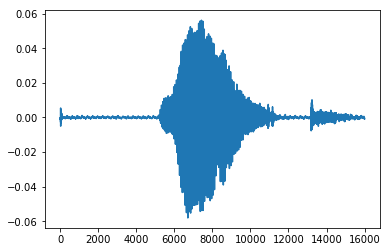

0.056215096

In [100]:
import matplotlib.pyplot as plt

plt.plot(wav_data)
plt.show()

np.max(wav_data)

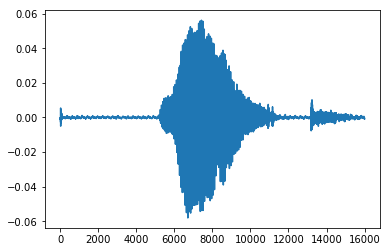

In [99]:
mix_wav = mix_background_noise(wav_data, 0.1, 0.1)

plt.plot(mix_wav)
plt.show()

## MFCC

MFCC Hyperparameters

In [27]:
window_size_samples = int(sample_rate * window_size_ms / 1000)
window_stride_samples = int(sample_rate * window_stride_ms / 1000)
length_minus_window = desired_samples - window_size_samples
if length_minus_window < 0:
    spectrogram_length = 0
else:
    spectrogram_length = 1 + int(length_minus_window
            / window_stride_samples)
fingerprint_size = dct_coefficient_count * spectrogram_length

In [28]:
import python_speech_features

def mfcc(wav, sample_rate=desired_samples, **kwargs):
    """从读出的音频数据中算出mfcc,具体可以看python_speech_features的文档

    Parameters:
        wav (np.ndarray): - 指明音频的振幅序列
        sample_rate (int): - 指明抽样率
        numcep (int): - 指明返回的倒数数量,默认为13

    Returns:
        np.ndarray: - mfcc强度(二维)组成的元组,shape为(times.shape,numcep)
    """
    return python_speech_features.mfcc(wav, sample_rate, **kwargs)

In [29]:
mfcc(wav_data, numcep = 26).shape

(99, 26)

-----
# Preprocess

In [30]:
def preprocess(fname, label, mode='train'):
    wav = load_wav_file(fname)
    wav = desired_samples_wav(wav)
    if mode=='train':
        wav = silence_as_zero(wav, label)
        wav = shift_and_pad_zeros(wav)
    wav = mix_background_noise(wav)
    return mfcc(wav,numcep=dct_coefficient_count), word_to_index[label]

## Generate Batches

In [31]:
itr = 0
all_data_index = data_index['training'] + data_index['testing'] + data_index['validation']

def all_data_generator(batch_size=batch_size):
    
    while 1:
        global itr
        if itr + batch_size >= len(all_data_index):
            itr = 0

        X_batches = []
        Y_batches = []

        for i in range(itr, itr+batch_size):
            fname = all_data_index[i]['file']
            label = all_data_index[i]['label']
            X_input, Y_input = preprocess(fname, label)
            X_batches.append(X_input)
            Y_batches.append(Y_input)
            
        itr = itr + batch_size

        yield np.array(X_batches), to_categorical(np.array(Y_batches).reshape(batch_size, 1), num_classes=label_count)

In [32]:
train_itr = 0
train_data_index = data_index['training']

def train_generator(batch_size=batch_size):
    
    while 1:
        global train_itr
        if train_itr + batch_size >= len(train_data_index):
            train_itr = 0

        X_batches = []
        Y_batches = []

        for i in range(train_itr, train_itr+batch_size):
            fname = train_data_index[i]['file']
            label = train_data_index[i]['label']
            X_input, Y_input = preprocess(fname, label)
            X_batches.append(X_input)
            Y_batches.append(Y_input)
            
        train_itr = train_itr + batch_size

        yield np.array(X_batches), to_categorical(np.array(Y_batches).reshape(batch_size, 1), num_classes=label_count)

In [33]:
val_itr = 0
val_data_index = data_index['validation']

def val_generator(batch_size=batch_size):
    
    while 1:
        global val_itr
        if val_itr + batch_size >= len(val_data_index):
            val_itr = 0

        X_batches = []
        Y_batches = []

        for i in range(val_itr, val_itr+batch_size):
            fname = val_data_index[i]['file']
            label = val_data_index[i]['label']
            X_input, Y_input = preprocess(fname, label, mode='val')
            X_batches.append(X_input)
            Y_batches.append(Y_input)
            
        val_itr = val_itr + batch_size

        yield np.array(X_batches), to_categorical(np.array(Y_batches).reshape(batch_size, 1), num_classes=label_count)

In [34]:
test_data_index = data_index['testing']

---
# Build Keras Model

In [35]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, GlobalAveragePooling1D, AveragePooling1D, Activation, Bidirectional
from keras.utils import to_categorical

from keras.layers import merge
from keras.layers.core import *
from keras.models import *

Using TensorFlow backend.


In [36]:
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

inputs = Input(shape=(INPUT_SHAPE))
# RNN Layer
if MODEL_TYPE == 'rnn':
    rnn_out = SimpleRNN(NUM_HIDDEN, return_sequences=True)(inputs)
elif MODEL_TYPE == 'gru':
    rnn_out = GRU(NUM_HIDDEN, return_sequences=True)(inputs)
elif MODEL_TYPE == 'lstm':
    rnn_out = LSTM(NUM_HIDDEN, return_sequences=True)(inputs)
elif MODEL_TYPE == 'bi-lstm':
    rnn_out = Bidirectional(LSTM(NUM_HIDDEN, return_sequences=True))(inputs)
else:
    raise NameError("Unsupported model type")
# Attention Layer
attention_mul = attention_3d_block(rnn_out)
attention_mul = Flatten()(attention_mul)
output = Dense(label_count, activation='softmax')(attention_mul)
model = Model(input=[inputs], output=output)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # This is added back by InteractiveShellApp.init_path()
/anaconda/lib/python3.6/site-packages/Keras-2.0.8-py3.6.egg/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 99, 26)       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 99, 200)      101600      input_1[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 200, 99)      0           bidirectional_1[0][0]            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 200, 99)      0           permute_1[0][0]                  
__________________________________________________________________________________________________
dense_1 (D

In [38]:
# Train model on all dataset
model.fit_generator(generator = all_data_generator(), 
                    steps_per_epoch = len(all_data_index)//batch_size,
                    # validation_data = val_generator(),
                    # validation_steps = len(val_data_index)//batch_size,
                    epochs=EPOCHE)

# Train model on train | test | val
'''
model.fit_generator(generator = train_generator(), 
                    steps_per_epoch = len(train_data_index)//batch_size,
                    validation_data = val_generator(),
                    validation_steps = len(val_data_index)//batch_size,
                    epochs=EPOCHE)
'''

Epoch 1/4
888/888 [==============================] - 349s - loss: 0.9658 - acc: 0.6994   
Epoch 2/4
888/888 [==============================] - 284s - loss: 0.4610 - acc: 0.8586   
Epoch 3/4
888/888 [==============================] - 284s - loss: 0.3550 - acc: 0.8910   
Epoch 4/4
888/888 [==============================] - 285s - loss: 0.3002 - acc: 0.9078   


'\nmodel.fit_generator(generator = train_generator(), \n                    steps_per_epoch = len(train_data_index)//batch_size,\n                    validation_data = val_generator(),\n                    validation_steps = len(val_data_index)//batch_size,\n                    epochs=EPOCHE)\n'

## See how it works on our split test data

In [39]:
test_data_index = data_index['testing']
correct_count = 0

for i in range(len(test_data_index)):
    fname = test_data_index[i]['file']
    label = test_data_index[i]['label']
    mfcc_, _ = preprocess(fname, label, mode='test')
    predictions = model.predict(mfcc_[np.newaxis,:,:])
    word = possible_labels[np.argmax( predictions[0] )]
    if word == label:
        correct_count = correct_count + 1
    if i % 100 == 0:
        print("Step {}/{}".format(i, len(test_data_index)))
        
print('Correct Prediction: {}/{}'.format(correct_count, len(test_data_index)))

Step 0/3081
Step 100/3081
Step 200/3081
Step 300/3081
Step 400/3081
Step 500/3081
Step 600/3081
Step 700/3081
Step 800/3081
Step 900/3081
Step 1000/3081
Step 1100/3081
Step 1200/3081
Step 1300/3081
Step 1400/3081
Step 1500/3081
Step 1600/3081
Step 1700/3081
Step 1800/3081
Step 1900/3081
Step 2000/3081
Step 2100/3081
Step 2200/3081
Step 2300/3081
Step 2400/3081
Step 2500/3081
Step 2600/3081
Step 2700/3081
Step 2800/3081
Step 2900/3081
Step 3000/3081
Correct Prediction: 2452/3081


# Generate final result

In [40]:
import glob    
import pandas as pd

test_files = glob.glob(os.path.join(data_dir,'test','audio','*.wav'))
test_filenames = [os.path.basename(f) for f in test_files]

In [41]:
test_files[0]

'/Users/yufan/Documents/workspace/kaggle-project/dataset/test/audio/clip_667ea2de0.wav'

In [46]:
num_test = len(test_files)
submission = []

for i in range(num_test):
    wav_mfcc, _ = preprocess(test_files[i], 'yes', mode='test') # Give a random label but this 'yes' is never used
    label = possible_labels[np.argmax( model.predict(wav_mfcc[np.newaxis,:,:]) )]
    submission.append([test_filenames[i], label])
    if i % 3000 == 0:
        print("Predicting {}/{}".format(i, num_test))
        
print("Finish predicting.....")

submissionDF = pd.DataFrame(submission, columns=['fname','label'])

print("Writing to file.....")
submissionDF.to_csv("submission-bi-lstm-attention-prepropcessing-1.csv", index=False, header=True)

Predicting 0/158538
Predicting 3000/158538
Predicting 6000/158538
Predicting 9000/158538
Predicting 12000/158538
Predicting 15000/158538
Predicting 18000/158538
Predicting 21000/158538
Predicting 24000/158538
Predicting 27000/158538
Predicting 30000/158538
Predicting 33000/158538
Predicting 36000/158538
Predicting 39000/158538
Predicting 42000/158538
Predicting 45000/158538
Predicting 48000/158538
Predicting 51000/158538
Predicting 54000/158538
Predicting 57000/158538
Predicting 60000/158538
Predicting 63000/158538
Predicting 66000/158538
Predicting 69000/158538
Predicting 72000/158538
Predicting 75000/158538
Predicting 78000/158538
Predicting 81000/158538
Predicting 84000/158538
Predicting 87000/158538
Predicting 90000/158538
Predicting 93000/158538
Predicting 96000/158538
Predicting 99000/158538
Predicting 102000/158538
Predicting 105000/158538
Predicting 108000/158538
Predicting 111000/158538
Predicting 114000/158538
Predicting 117000/158538
Predicting 120000/158538
Predicting 12300

In [47]:
submissionDF

,fname,label
0,clip_667ea2de0.wav,yes
1,clip_4e1d2a516.wav,go
2,clip_4746c1f34.wav,unknown
3,clip_016404de8.wav,on
4,clip_dcb5708d7.wav,no
5,clip_af77b5fb6.wav,on
6,clip_a78b014de.wav,unknown
7,clip_25f0146ae.wav,silence
8,clip_f109a09ec.wav,down
9,clip_160d3ee69.wav,silence
